# Project 3: Collaborative Filtering [Q16-29]
**ECE 219**: Large-Scale Data Mining: Models and Algorithms [Winter 2021]

Prof. Vwani Roychowdhury

UCLA, Department of ECE

**Due**: 2021.02.19 11:59PM PT

# Q16

Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For $U$ fixed, formulate it as a least-squares problem.

**ANSWER**

No, it is not convex. For a fixed $U$, the problem simply minimizes $V$ instead:

$$
\min_V \sum_{i=1}^m \sum_{j=1}^n W_{ij} (r_{ij} - (UV^T)_{ij})^2
$$

# Q17

Design a NNMF-based collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis). For solving this question, use the default value for the regularization parameter.

In [10]:
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import train_test_split
from surprise import Dataset, Reader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [13]:
reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1, rating_scale=(0.5, 5))
file_path = 'ratings.csv'
data = Dataset.load_from_file(file_path, reader=reader)

In [17]:
ks = np.arange(2, 51, 2)

results = []
for k in ks:
    print('Running with {} factors...'.format(k))
    perf = cross_validate(NMF(n_factors=k), data, cv=10)
    results.append([k, perf['test_rmse'].mean(), perf['test_mae'].mean()])
    
df = pd.DataFrame(results, columns=['ks', 'avg_rmse', 'avg_mae']).set_index('ks')

Running with 2 factors...
Running with 4 factors...
Running with 6 factors...
Running with 8 factors...
Running with 10 factors...
Running with 12 factors...
Running with 14 factors...
Running with 16 factors...
Running with 18 factors...
Running with 20 factors...
Running with 22 factors...
Running with 24 factors...
Running with 26 factors...
Running with 28 factors...
Running with 30 factors...
Running with 32 factors...
Running with 34 factors...
Running with 36 factors...
Running with 38 factors...
Running with 40 factors...
Running with 42 factors...
Running with 44 factors...
Running with 46 factors...
Running with 48 factors...
Running with 50 factors...


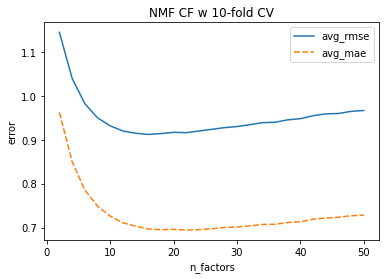

In [59]:
g = sns.lineplot(data=df)
g.set_xlabel('n_factors')
g.set_ylabel('error')
g.set_title('NMF CF w 10-fold CV')
plt.show()

# Q18

Use the plot from question 17, to find the optimal number of latent factors.
Optimal number of latent factors is the value of $k$ that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

**ANSWER**

```
Minimum Average RMSE: 0.912127 @ k=16
Minimum Average MAE:  0.694464 @ k=22
```

The $k_{min} \in \{16,22\}$ do seem to roughly correspond to the 18 tracked movie genres. 

NOTE: I excluded `(no genres listed)` and `IMAX` from the total genre count because these do not seem to be valid. The former is the `NULL` class and it is likely that a genre could be assigned by some expert. The latter is just a type of theater / movie format.

In [6]:
import itertools

In [92]:
genres = pd.read_csv('movies.csv').genres.tolist()
genres = [x.split('|') for x in genres]
distinct_genres = set(itertools.chain(*genres))
print('Number of Genres: {} \n {}'.format(len(distinct_genres), distinct_genres))

Number of Genres: 20 
 {'Children', 'IMAX', 'Musical', 'Western', 'Horror', 'Action', 'Crime', 'Drama', '(no genres listed)', 'Romance', 'Documentary', 'Fantasy', 'Sci-Fi', 'Comedy', 'Mystery', 'Adventure', 'Film-Noir', 'Thriller', 'War', 'Animation'}


In [72]:
df.sort_values('avg_rmse').head(1)

,avg_rmse,avg_mae
ks,,
16,0.912127,0.696921


In [73]:
df.sort_values('avg_mae').head(1)

,avg_rmse,avg_mae
ks,,
22,0.916132,0.694464


# Q19

Design a NNMF collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE. 

In [7]:
from surprise.model_selection import KFold
from surprise import accuracy

from collections import defaultdict 
from tqdm.notebook import tqdm

In [21]:
def MF_plot(MF_type='NMF', trim=None, biased=False, n_folds=10, ks=np.arange(2, 51, 2)):
    
    reader = Reader(line_format='user item rating timestamp', sep=',',skip_lines=1, rating_scale=(0.5, 5))
    file_path = 'ratings.csv'
    data = Dataset.load_from_file(file_path, reader=reader)
    
    mvr = defaultdict(list) 
    for r in data.raw_ratings:
        mvr[r[1]].append(r[2])

    kf = KFold(n_splits=n_folds)
    
        
    results = []
    for k in tqdm(ks):
        
        if MF_type == 'NMF':
            MF = NMF(n_factors=k, biased=biased)
        elif MF_type == 'SVD':
            MF = SVD(n_factors=k, biased=biased)

        rmse = 0
        for train, test in kf.split(data):
            if trim == 'Popular':
                test = [r for r in test if len(mvr[r[1]]) > 2]
            elif trim == 'Unpopular':
                test = [r for r in test if len(mvr[r[1]]) <= 2]
            elif trim == 'High Variance':
                test = [r for r in test if (len(mvr[r[1]]) >= 5 and np.var(mvr[r[1]]) >= 2)]
            pred = MF.fit(train).test(test)
            rmse += accuracy.rmse(pred, verbose=False)
        results.append([k, rmse / n_folds])

    df = pd.DataFrame(results, columns=['ks', 'avg_rmse']).set_index('ks')
    
    g = sns.lineplot(data=df)
    g.set_xlabel('n_factors')
    g.set_ylabel('error')
    g.set_title(MF_type + ' CF w 10-fold CV | ' + trim + ' Movie Trimming')
    plt.show()
    
    print(df.sort_values('avg_rmse').head(1))

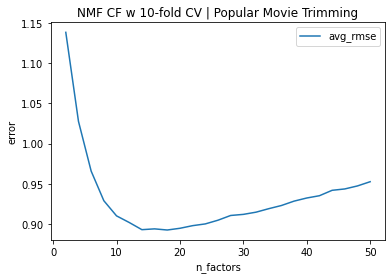

    avg_rmse
ks          
18  0.892921


In [428]:
MF_plot(MF_type='NMF', trim="Popular")

# Q20


Design a NNMF collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE. 

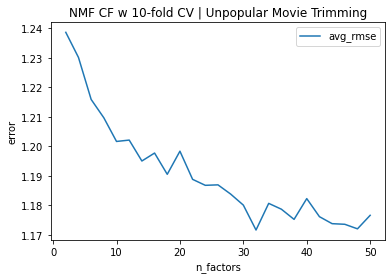

    avg_rmse
ks          
32  1.171689


In [429]:
MF_plot(MF_type='NMF', trim="Unpopular")

# Q21

Design a NNMF collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE. 

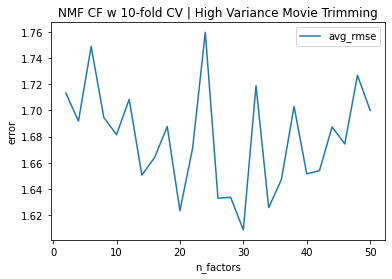

    avg_rmse
ks          
30   1.60866


In [430]:
MF_plot(MF_type='NMF', trim="High Variance")

# Q22

Plot the ROC curves for the NNMF-based collaborative filter designed in question 17 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question 18. For each of the plots, also report the area under the curve (AUC) value.

In [28]:
from sklearn.metrics import roc_curve, auc

In [26]:
def plot_roc_curve(model, data, threshold, title=None):
    train, test = train_test_split(data, train_size=0.9, test_size=0.1)
    y_pred = model.fit(train).test(test)
    y_true = [0 if y.r_ui < threshold else 1 for y in y_pred]
    y_pred = [y.est for y in y_pred]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    if title:
        plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

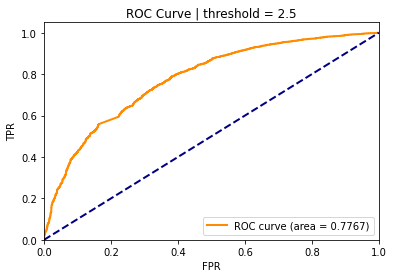

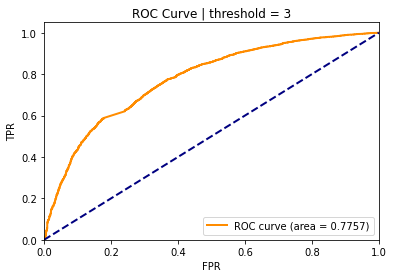

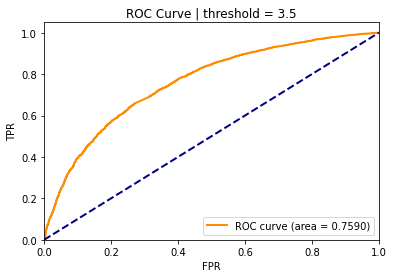

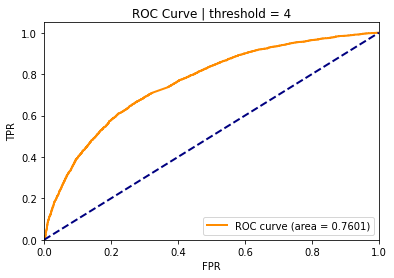

In [436]:
best_k = 16
nmf = NMF(n_factors=best_k)

thresholds = [2.5, 3, 3.5, 4]
for t in thresholds:
    plot_roc_curve(nmf, data, t, "ROC Curve | threshold = " + str(t))

# Q23

Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices $U$ and $V$, where $U$ represents the user-latent factors interaction and $V$ represents the movie-latent factors interaction (use k = 20). For each column of $V$, sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

**ANSWER**

Each latent factor (LF) seems to correspond to a relatively small collection of genres, but they aren't particularly distinctive. For each LF, we plotted the distribution of movie genre assignments to see which were the most prevalent. The lowest number of unique genres was 7 and the highest was 14. The most number of movies belonging to the same genre for a given LF was 7 out of 10, and 4 out of 10 for the lowest. 

As for the connection between the LFs and the genres, there does seem to be a weak connection between them. For example LF={19} shows a strong presence of thriller, LF={1,2,8,12} for comedy, but many others show the dominance of drama in the genre assignments. 

In [9]:
def get_latent_factor_details(genres, k):
    genres, counts = np.unique(genres, return_counts=True)
    print("unique genres: {}".format(len(genres)))
    print("total genres:  {}".format(counts.sum()))
    
    m_df = pd.DataFrame([genres, counts]).T
    m_df.rename(columns={0:'genres',1:'counts'}, inplace=True)
    
    g=sns.barplot(
        data=m_df, 
        x=m_df.index, 
        y='counts',
        palette='flare'
    )
    g.set_xticklabels(m_df.genres, rotation=90)
    g.set_title("Distribution of Genres for k=" + str(k))
    plt.show()

In [306]:
movies_df = pd.read_csv('movies.csv')
train, test = train_test_split(data, train_size=0.9, test_size=0.1)

In [312]:
nmf = NMF(n_factors=20)
nmf.fit(train).test(test)
U, V = nmf.pu, nmf.qi

latent_factor: 0
unique genres: 12
total genres:  18


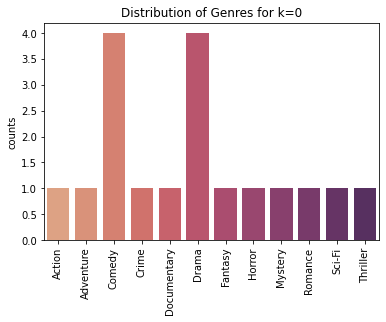

latent_factor: 1
unique genres: 12
total genres:  23


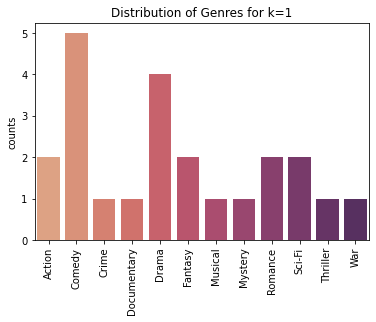

latent_factor: 2
unique genres: 11
total genres:  18


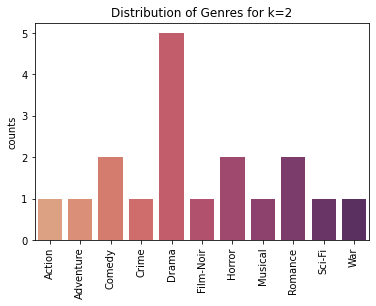

latent_factor: 3
unique genres: 10
total genres:  27


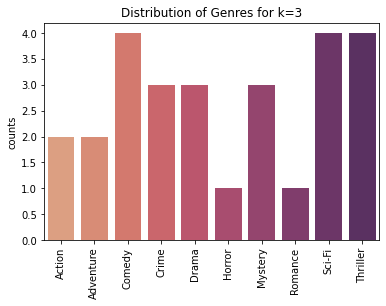

latent_factor: 4
unique genres: 13
total genres:  23


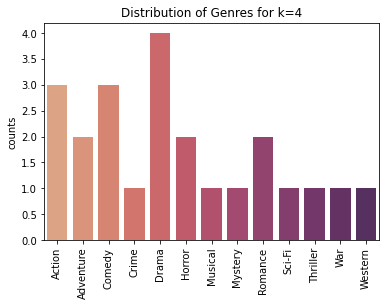

latent_factor: 5
unique genres: 9
total genres:  19


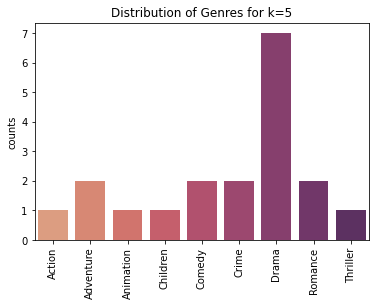

latent_factor: 6
unique genres: 7
total genres:  15


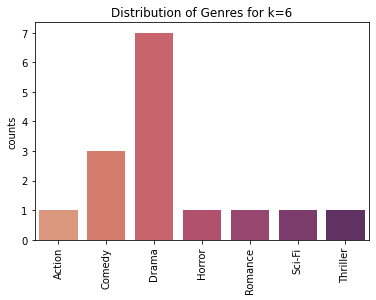

latent_factor: 7
unique genres: 11
total genres:  18


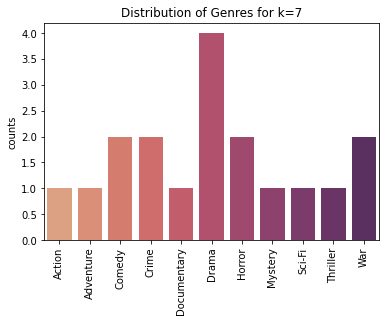

latent_factor: 8
unique genres: 10
total genres:  23


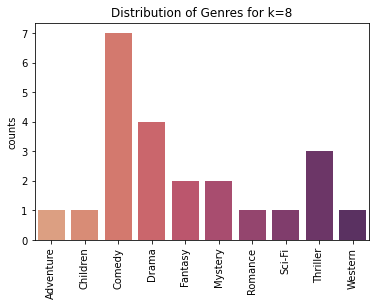

latent_factor: 9
unique genres: 13
total genres:  27


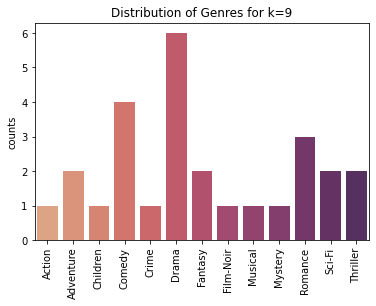

latent_factor: 10
unique genres: 13
total genres:  25


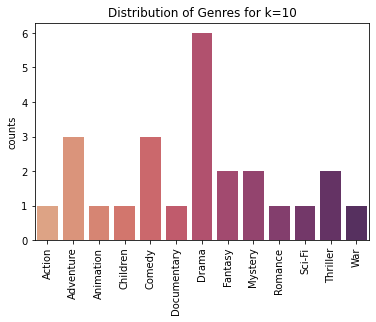

latent_factor: 11
unique genres: 13
total genres:  29


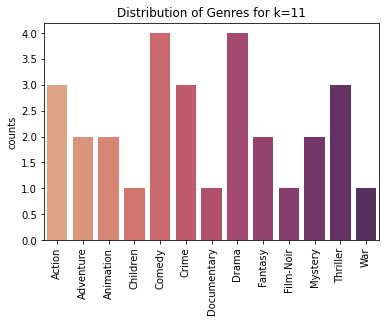

latent_factor: 12
unique genres: 11
total genres:  23


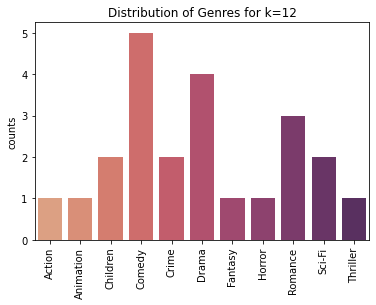

latent_factor: 13
unique genres: 10
total genres:  22


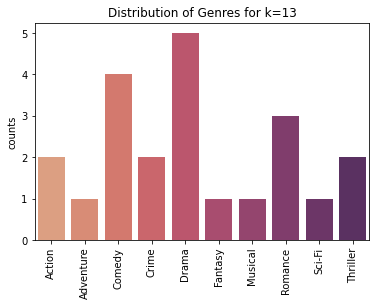

latent_factor: 14
unique genres: 9
total genres:  18


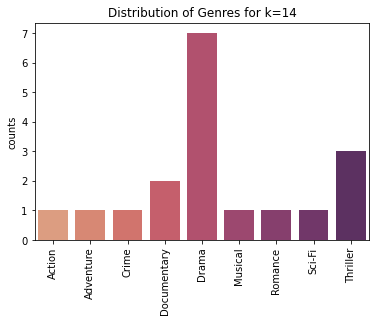

latent_factor: 15
unique genres: 9
total genres:  22


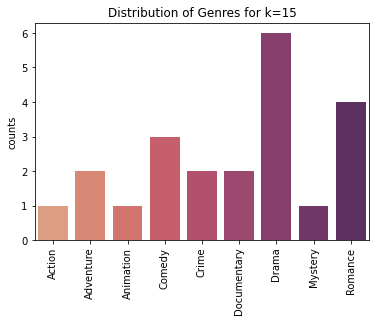

latent_factor: 16
unique genres: 14
total genres:  33


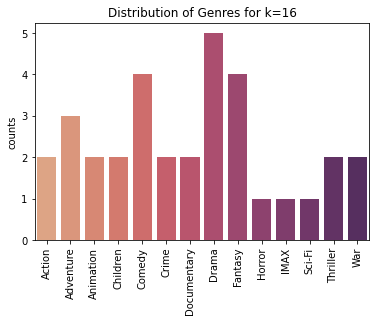

latent_factor: 17
unique genres: 8
total genres:  23


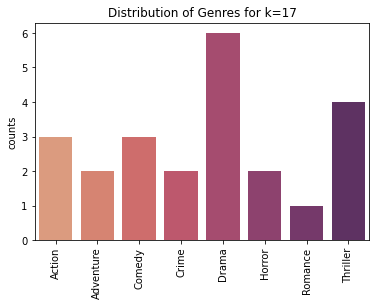

latent_factor: 18
unique genres: 14
total genres:  28


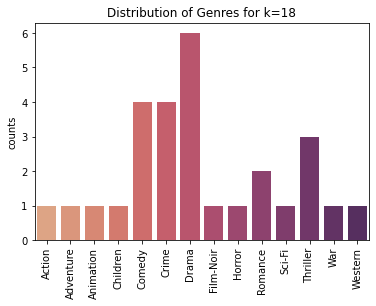

latent_factor: 19
unique genres: 13
total genres:  27


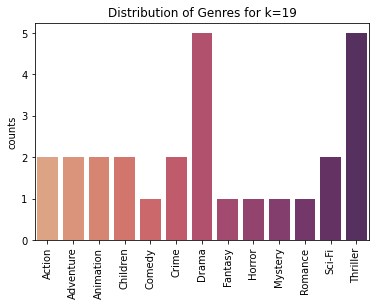

In [411]:
for k in np.arange(0, 20):
    print('latent_factor: {}'.format(k))
    movies = [(n,j) for n,j in enumerate(V[:,k])]
    movies.sort(key=lambda x: x[1], reverse=True)
    genres = []
    for m in movies[:10]:
        genres.extend(movies_df['genres'].iloc[m[0]].split("|"))
    get_latent_factor_details(genres, k)

# Q24

Design a MF with bias collaborative filter to predict the ratings of the movies in the MovieLens dataset and evaluate it's performance using 10-fold cross-validation. Sweep $k$ (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against $k$ (X-axis) and the average MAE (Y-axis) against $k$ (X-axis). For solving this question, use the default value for the regularization parameter.

In [4]:
from surprise.prediction_algorithms.matrix_factorization import SVD

In [14]:
ks = np.arange(2, 51, 2)

results = []
for k in ks:
    print('Running with {} factors...'.format(k))
    perf = cross_validate(SVD(n_factors=k, biased=True), data, cv=10)
    results.append([k, perf['test_rmse'].mean(), perf['test_mae'].mean()])
    
df = pd.DataFrame(results, columns=['ks', 'avg_rmse', 'avg_mae']).set_index('ks')

Running with 2 factors...
Running with 4 factors...
Running with 6 factors...
Running with 8 factors...
Running with 10 factors...
Running with 12 factors...
Running with 14 factors...
Running with 16 factors...
Running with 18 factors...
Running with 20 factors...
Running with 22 factors...
Running with 24 factors...
Running with 26 factors...
Running with 28 factors...
Running with 30 factors...
Running with 32 factors...
Running with 34 factors...
Running with 36 factors...
Running with 38 factors...
Running with 40 factors...
Running with 42 factors...
Running with 44 factors...
Running with 46 factors...
Running with 48 factors...
Running with 50 factors...


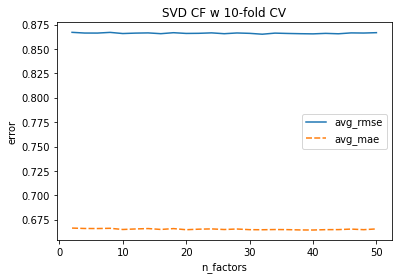

In [15]:
g = sns.lineplot(data=df)
g.set_xlabel('n_factors')
g.set_ylabel('error')
g.set_title('SVD CF w 10-fold CV')
plt.show()

In [16]:
df.sort_values('avg_rmse').head(1)

,avg_rmse,avg_mae
ks,,
32,0.865094,0.664705


In [17]:
df.sort_values('avg_mae').head(1)

,avg_rmse,avg_mae
ks,,
40,0.865446,0.664435


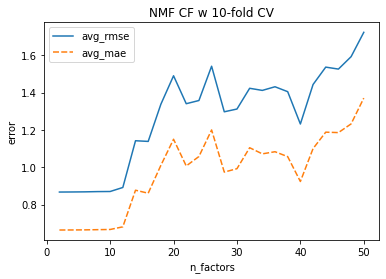

In [416]:
g = sns.lineplot(data=df)
g.set_xlabel('n_factors')
g.set_ylabel('error')
g.set_title('NMF CF w 10-fold CV')
plt.show()

In [417]:
df.sort_values('avg_rmse').head(1)

,avg_rmse,avg_mae
ks,,
2,0.867691,0.664269


In [418]:
df.sort_values('avg_mae').head(1)

,avg_rmse,avg_mae
ks,,
2,0.867691,0.664269


# Q25

Use the plot from question 24, to find the optimal number of latent factors.
Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE.

**ANSWER**

```
Minimum Average RMSE: 0.867691 @ k=2
Minimum Average MAE:  0.664269 @ k=2
```

# Q26

Design a MF with bias collaborative filter to predict the ratings of the movies in the popular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

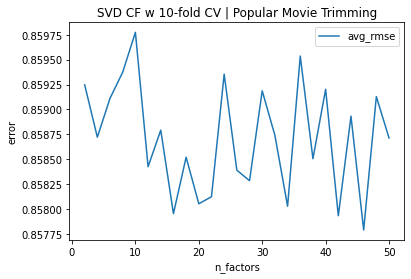

    avg_rmse
ks          
46   0.85779


In [22]:
MF_plot(MF_type='SVD', trim="Popular", biased=True)

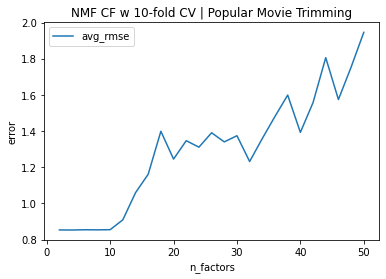

    avg_rmse
ks          
4   0.853147


In [431]:
MF_plot(MF_type='NMF', trim="Popular", biased=True)

# Q27

Design a MF with bias collaborative filter to predict the ratings of the movies in the unpopular movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

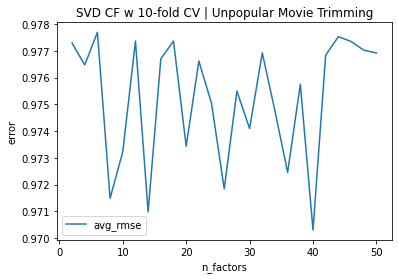

    avg_rmse
ks          
40  0.970299


In [23]:
MF_plot(MF_type='SVD', trim="Unpopular", biased=True)

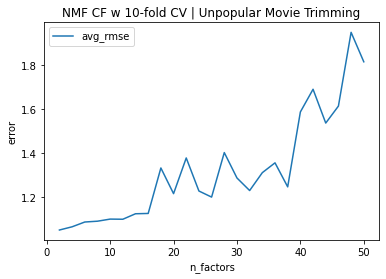

    avg_rmse
ks          
2   1.052906


In [432]:
MF_plot(MF_type='NMF', trim="Unpopular", biased=True)

# Q28

Design a MF with bias collaborative filter to predict the ratings of the movies in the high variance movie trimmed test set and evaluate it's performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

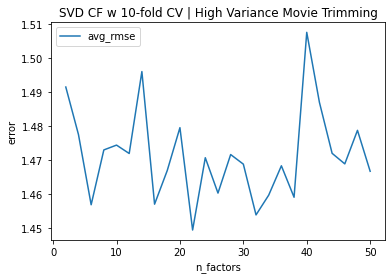

    avg_rmse
ks          
22  1.449506


In [24]:
MF_plot(MF_type='SVD', trim="High Variance", biased=True)

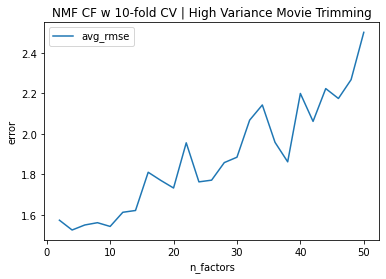

    avg_rmse
ks          
4   1.524563


In [433]:
MF_plot(MF_type='NMF', trim="High Variance", biased=True)

# Q29

Plot the ROC curves for the MF with bias collaborative filter designed in question 24 for threshold values [2.5, 3, 3.5, 4]. For the ROC plotting use the optimal number of latent factors found in question 25. For each of the plots, also report the area under the curve (AUC) value.

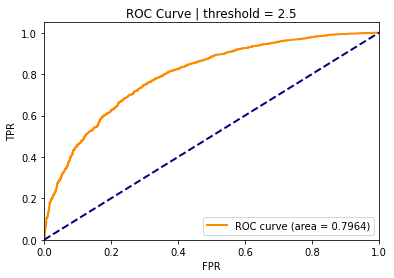

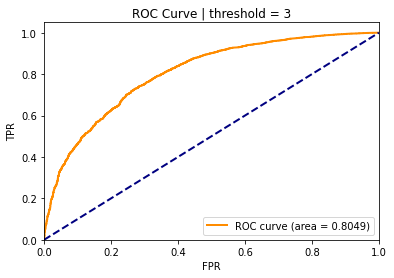

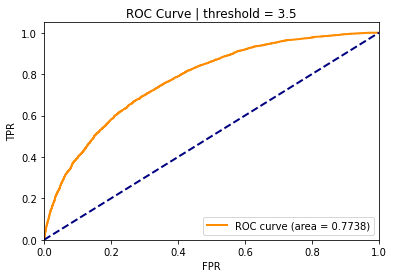

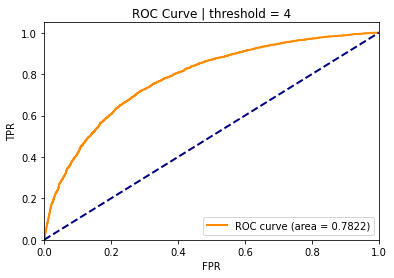

In [29]:
best_k = 32
svd = SVD(n_factors=best_k, biased=True)

thresholds = [2.5, 3, 3.5, 4]
for t in thresholds:
    plot_roc_curve(svd, data, t, "ROC Curve | threshold = " + str(t))

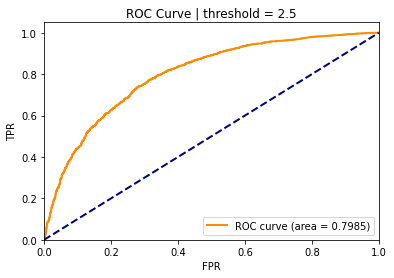

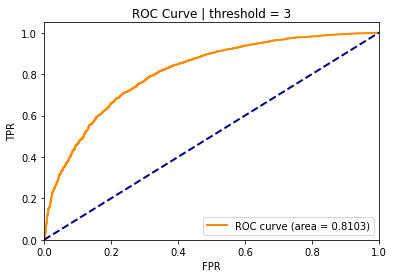

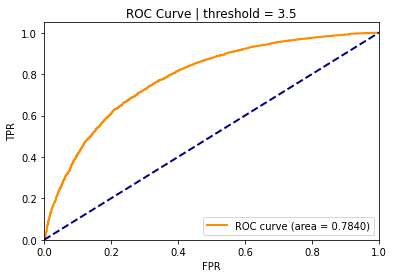

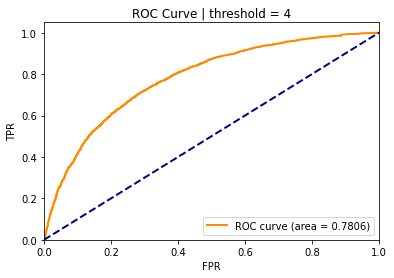

In [437]:
best_k = 2
nmf = SVD(n_factors=best_k, biased=True)

thresholds = [2.5, 3, 3.5, 4]
for t in thresholds:
    plot_roc_curve(nmf, data, t, "ROC Curve | threshold = " + str(t))